# Fatal Encounters Report
> A. Lecomte <alexis.lecomte@supinfo.com>

## Importation des bibliothèques

In [1]:
# Calculs mathématiques
import math
import numpy

# Chargement et prise en charge des données
import pandas

# Prise en charge des données géographique
import geopandas
from geopandas import GeoDataFrame
import folium
from folium import plugins

# Création de statistiques et de graphiques
import scipy.stats
import matplotlib.pyplot as pyplot

# Autres
import os
import re
import time
from tabulate import tabulate
import webbrowser
from colorama import Fore, Style

Après l'importation des bibliothèques, nous initialisons certains modules.

In [2]:
%matplotlib notebook
pyplot.style.use("ggplot")
pyplot.rcParams["figure.figsize"] = [17, 7]

## Chargement des données
Nous importons le fichier CSV en spécifiant les types de chaque colonne. Ainsi, le chargement est plus rapide, car pandas n'as pas besoin de deviner le type de chacune des colonnes. Et cela permet aussi définir le type que nous souhaitons avoir, laissant ainsi moins de place au hasard.

In [3]:
data_fe = pandas.read_csv("../data/FatalEncounters.csv", dtype={
	"Unique ID": float,
	"Name": str,
	"Age": str,
	"Gender": "category",
	"Race": "category",
	"Race with imputations": "category",
	"URL of image (PLS NO HOTLINKS)": str,
	"Date of injury resulting in death (month/day/year)": "datetime64[ns]",
	"Location of injury (address)": str,
	"Location of death (city)": str,
	"State": str,
	"Location of death (zip code)": str,
	"Location of death (country)": str,
	"Full Address": str,
	"Latitude": str,
	"Longitude": float,
	"Agency or agencies involved": str,
	"Highest level of force": "category",
	"UID Temporary": str,
	"Name Temporary": str,
	"Armed/Unarmed": str,
	"Alleged weapon": str,
	"Aggressive physical movement": str,
	"Fleeing/Not fleeing": str,
	"Description Temp": str,
	"URL Temp": str,
	"Brief description": str,
	"Dispositions/Exclusions INTERNAL USE, NOT FOR ANALYSIS": object,
	"Intended use of force (Developing)": str,
	"Supporting document link": str,
	"Foreknowledge of mental illness? INTERNAL USE, NOT FOR ANALYSIS": object,
	"Unnamed: 32": float,
	"Unnamed: 33": float,
	"Unique ID formula": float,
	"Unique identifier (redundant)": float
})

Nous pouvons noter que certaines des colonnes n'ont pas un type qui semble adéquat. Par exemple, la latitude qui est une `str` plutôt qu'un `float`. En effet, cette colonne comporte des données erronées qui empêche d'interpréter chacune de ses valeurs comme un `float`. Nous réglerons le problème après avoir préparé les données.

## Premier aperçu

In [4]:
print(f"Shape: {Fore.LIGHTGREEN_EX}{data_fe.shape}{Fore.RESET}")
print(data_fe.head(n=5))
print(f"Columns type: {Style.DIM}{Fore.WHITE}\n{data_fe.dtypes}{Style.RESET_ALL}")

Shape: (31498, 36)
   Unique ID                   Name Age  Gender                     Race  \
0    25746.0        Samuel H. Knapp  17    Male  European-American/White   
1    25747.0         Mark A. Horton  21    Male   African-American/Black   
2    25748.0  Phillip A. Blurbridge  19    Male   African-American/Black   
3    25749.0             Mark Ortiz  23    Male          Hispanic/Latino   
4        1.0  LaTanya Janelle McCoy  24  Female   African-American/Black   

     Race with imputations Imputation probability  \
0  European-American/White            Not imputed   
1   African-American/Black            Not imputed   
2   African-American/Black            Not imputed   
3          Hispanic/Latino            Not imputed   
4   African-American/Black            Not imputed   

  URL of image (PLS NO HOTLINKS)  \
0                            NaN   
1                            NaN   
2                            NaN   
3                            NaN   
4                        

### Unicité des colonnes "Unique ID" et "Name"
Nous cherchons ici à vérifier que ces deux colonnes sont uniques. Nous nous attendons à ce que la colonne "Unique ID" **soit** unique. Cependant, le nom peut comporter quelques doublons.

In [5]:
def is_column_unique(col_name, display_name=None):
	display_name = display_name if display_name else col_name
	is_unique = data_fe[col_name].is_unique
	print(f"Is the \"{display_name}\" unique?: {Fore.LIGHTGREEN_EX}{is_unique}{Fore.RESET}")

	if not is_unique:
		columns_to_print = ["Unique ID"]

		if col_name not in columns_to_print:
			columns_to_print.append(col_name)

		duplicated = data_fe[data_fe.duplicated(subset=[col_name], keep=False)][columns_to_print]
		duplicated["Count"] = duplicated.groupby(col_name)["Unique ID"].transform("count")

		print((
			f"The non-unique \"{display_name}\" are:\n"
			f"{Style.DIM}{Fore.WHITE}{duplicated.drop_duplicates([col_name])}{Style.RESET_ALL}"
		))

is_column_unique("Unique ID", display_name="id")
is_column_unique("Name")

Is the "id" unique?: True
Is the "Name" unique?: False
The non-unique "Name" are:
       Unique ID                      Name  Count
22       20792.0   Name withheld by police   1391
98          59.0              Donald Moore      2
195      28746.0                John Doe 1      5
196      28747.0                John Doe 2      5
197      28748.0                John Doe 3      4
...          ...                       ...    ...
28227    28093.0       William Johnson Jr.      2
28248    28113.0              Dion Johnson      2
30806    30781.0              Eric Padilla      2
30820    30790.0     Devonte Dawayne Brown      2
31134    31134.0  Christopher Ryan Vasquez      2

[208 rows x 3 columns]


### Valeurs manquantes par colonnes
Nous allons maintenant essayer de voir la quantité (en pourcentage) de valeurs manquantes pour chacune des colonnes de notre jeu de données.

In [6]:
print((
	"Total percent of missing values: "
	f"{Fore.LIGHTGREEN_EX}{round(((data_fe.isna().sum().sum() / (data_fe.shape[0] * data_fe.shape[1])) * 100), 2)}%{Fore.RESET}"
))

percent_missing = round((data_fe.isna().sum() * 100) / len(data_fe), 2)
df_missing = pandas.DataFrame({"Column name": data_fe.columns, "Missing": percent_missing.values})
df_missing.sort_values("Missing", ascending=False, inplace=True)

print((
	f"Percent of missing values per columns:\n"
	f"{Style.DIM}{Fore.WHITE}{tabulate(df_missing, showindex=False, headers=df_missing.columns)}{Style.RESET_ALL}"
))

Total percent of missing values: 24.75%
Percent of missing values per columns:
Column name                                                        Missing
---------------------------------------------------------------  ---------
Unnamed: 33                                                         100
Unnamed: 32                                                         100
Unique ID formula                                                    99.99
URL Temp                                                             89.79
Description Temp                                                     87.09
UID Temporary                                                        82.45
Name Temporary                                                       82.45
URL of image (PLS NO HOTLINKS)                                       53.24
Armed/Unarmed                                                        45.78
Fleeing/Not fleeing                                                  45.78
Alleged weapon             

Nous allons ensuite supprimer toutes les colonnes avec plus de x% (`threshold`) de données manquantes.

In [7]:
# Drop all columns with more than `drop_threshold`% of missing data
drop_threshold = 50
drop_columns = df_missing[df_missing["Missing"] >= drop_threshold]['Column name'].tolist()

if len(drop_columns) > 0:
	print((
		f"{Fore.YELLOW}Dropping all columns with more than {drop_threshold}% of missing data. Dropping "
		f"{drop_columns}...{Fore.RESET}"
	))
	drop_prev_shape = data_fe.shape
	data_fe.drop(columns=drop_columns, axis=1, inplace=True)
	drop_new_shape = data_fe.shape
	drop_count = drop_prev_shape[1] - drop_new_shape[1]
	print(f"{Fore.YELLOW}Dropped {drop_count} column{'s' if drop_count > 1 else ''}. New shape: {drop_new_shape}{Fore.RESET}")

Dropping all columns with more than 50% of missing data. Dropping ['Unnamed: 33', 'Unnamed: 32', 'Unique ID formula', 'URL Temp', 'Description Temp', 'UID Temporary', 'Name Temporary', 'URL of image (PLS NO HOTLINKS)']...
Dropped 8 columns. New shape: (31498, 28)


### Valeurs dupliquées
Pour clore ce premier aperçu, nous allons compter le nombre de données dupliquées.

In [8]:
duplicated_data = data_fe.duplicated().sum()
print((
	f"Duplicated values: {Fore.LIGHTGREEN_EX}{duplicated_data}{Fore.RESET}"
	f" ({round((duplicated_data * 100) / data_fe.shape[0], 1)}%)"
))

Duplicated values: 0 (0.0%)


## Préparation des données
Avant toute analyse approfondie des données, il faut les préparer. Et notamment régler les problèmes de valeur pour certaines colonnes.

### Suppression des colonnes à ne pas utiliser
Certaines colonnes comportent dans leur nom la mention "INTERNAL USE, NOT FOR ANALYSIS". Pour respecter cette mention, nous supprimons ces colonnes.

In [9]:
data_fe.drop(list(data_fe.filter(regex="INTERNAL USE, NOT FOR ANALYSIS")), axis=1, inplace=True)

### Préparation de la colonne "Age"
Cette colonne ne pouvait pas être mise sous le type `float` car certaines de ses valeurs n'était pas numériques.

Certaines valeurs sont des intervalles d'âge. Deux choix sont alors possibles. Supprimer les lignes concernées ou transformer l'intervalle en moyenne. Nous avons choisi ici la deuxième solution. Pour régler le souci, nous appliquons une fonction de transformation sur la colonne.

In [10]:
def _transform_age(age):
	if isinstance(age, str):
		if "-" in age and not age.startswith("-"):
			age_range = age.split("-")
			return round(float((int(age_range[0]) + int(age_range[1])) / 2), 0)
		else:
			return round(float(age), 0)

	return round(age, 0)


data_fe["Age"] = data_fe["Age"].map(lambda age: _transform_age(age))

### Préparation de la colonne "Latitude"
Certaines latitudes comportent des caractères invalides. La solution la plus simple les concernant et de supprimer les lignes en question.

In [11]:
wrong_latitude_index = []

def _transform_latitude(lat):
	if isinstance(lat, str):
		try:
			return float(lat)
		except ValueError:
			wrong_latitude_index.append(data_fe.index[data_fe["Latitude"] == lat])
			return lat

	return lat

data_fe["Latitude"] = data_fe["Latitude"].map(lambda lat: _transform_latitude(lat))
data_fe.drop([index for sublist in wrong_latitude_index for index in sublist], inplace=True)
data_fe = data_fe.astype({"Latitude": float})

### Préparation de la colonne "Race"
Cette colonne pose deux problèmes. Le premier est que certaines cellules sont vides où contienne des valeurs incorrectes. Le second concerne la manière dont les ethnies sont renseignée. Chaque personne est caractérisée par une série d'ethnies séparées par un slash (/). Cependant, ce format rend compliqué l'analyse des données. Nous allons donc procéder à un `One Hot Encoding` afin de remplacer cette colonne par plusieurs colonnes correspondant à chacune des ethnies. Les valeurs de ces colonnes seront binaire, c'est-à-dire 0 où 1.

In [12]:
race_uncertain = "Race unspecified"
data_fe["Race"].fillna(race_uncertain, inplace=True)
data_fe["Race"] = data_fe["Race"].map(lambda race: race.title())
data_fe.loc[(data_fe["Race"] == "Christopher Anthony Alexander"), "Race"] = race_uncertain
data_fe = pandas.concat([
	data_fe.drop("Race", axis=1),
	data_fe["Race"].str.get_dummies(sep="/").add_prefix("Race_")
], axis=1)

### Préparation de la colonne "Armed/Unarmed"
Cette colonne, tout comme "Fleeing/Not fleeing", et une colonne qui comporte un nombre important de valeurs manquantes. Cependant, elle peut être très utile à l'étude. Pour chacune des personnes, cette colonne à pour valeur "Armed" (armé), "Unarmed" (non armé) ou "Uncertain" (incertain). Nous allons donc remplacer les valeurs incorrectes ou nulles par "Uncertain".

In [13]:
armed_uncertain = "Uncertain"

def _transform_is_armed(is_armed):
	if isinstance(is_armed, str):
		if (is_armed.lower() == "armed") or (is_armed.lower() == "unarmed"):
			return is_armed
		elif re.match(r"duplicate|none", is_armed, flags=re.IGNORECASE):
			return armed_uncertain
		else:
			return armed_uncertain
	else:
		return armed_uncertain

data_fe["Armed/Unarmed"] = data_fe["Armed/Unarmed"].map(lambda is_armed: _transform_is_armed(is_armed))
data_fe = data_fe.astype({"Armed/Unarmed": "category"})

### Préparation de la colonne "Fleeing/Not fleeing"
Nous avons le même intérêt pour cette colonne que "Armed/Unarmed", et elle comporte le même problème. Nous allons donc procéder de manière similaire.

In [14]:
fleeing_uncertain = "Uncertain"

def _transform_is_fleeing(is_fleeing):
	if isinstance(is_fleeing, str):
		if re.match(r"duplicate|none", is_fleeing, flags=re.IGNORECASE):
			return fleeing_uncertain
		else:
			parts = is_fleeing.lower().split("/")

			if "fleeing" in parts:
				return "Fleeing"
			elif "not fleeing" in parts:
				return "Not fleeing"
			elif fleeing_uncertain.lower() in parts:
				return fleeing_uncertain
			else:
				return fleeing_uncertain
	else:
		return fleeing_uncertain

data_fe["Fleeing/Not fleeing"] = data_fe["Fleeing/Not fleeing"].map(lambda is_fleeing: _transform_is_fleeing(is_fleeing))
data_fe = data_fe.astype({"Fleeing/Not fleeing": "category"})

Maintenant que nos transformations sont terminées, nous pouvons commencer à exploiter ce jeu de données pour une analyse statistique.

## Analyse de la fréquence

<IPython.core.display.Javascript object>


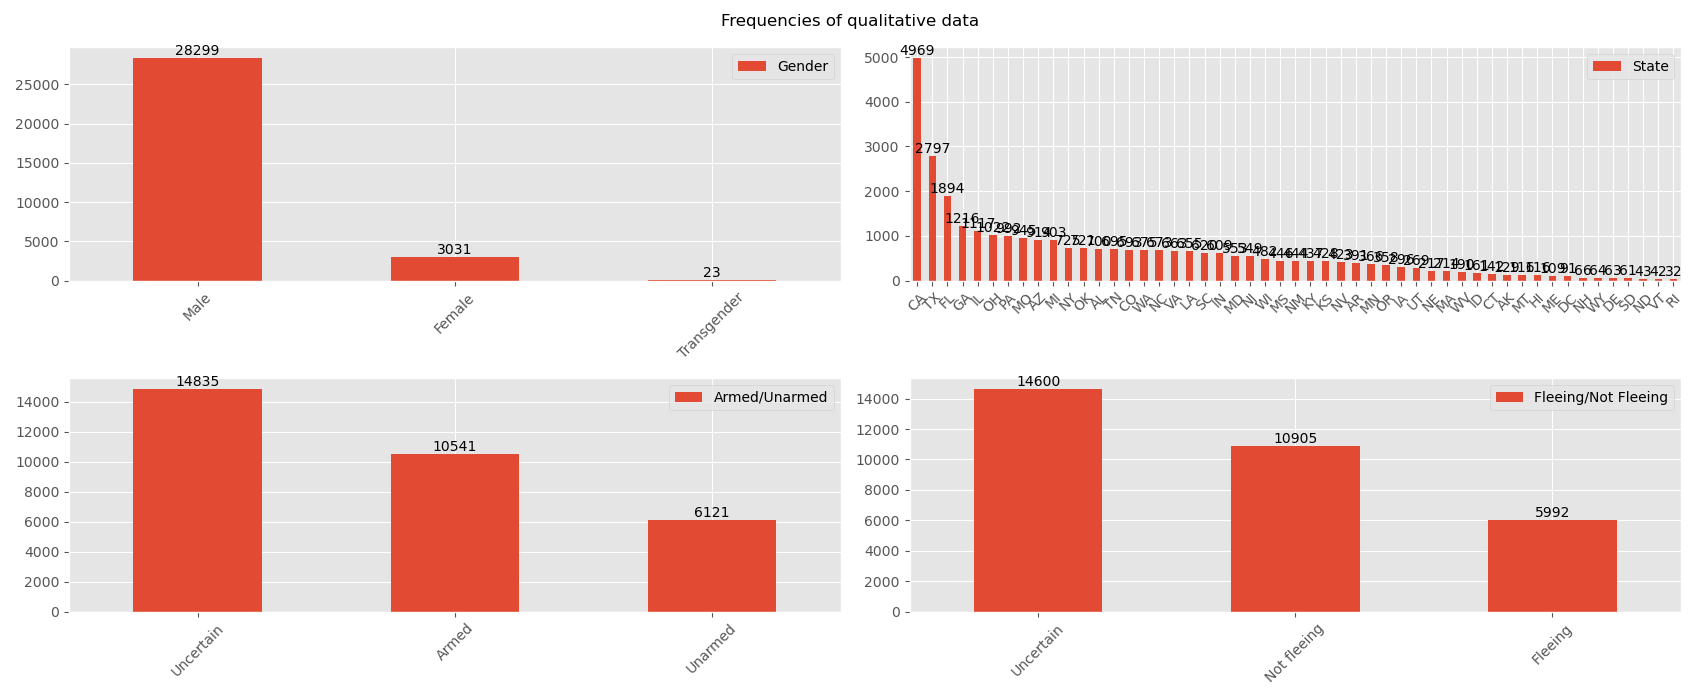

In [15]:
freq_columns = ["Gender", "State", "Armed/Unarmed", "Fleeing/Not fleeing"]
freq_n_cols = 2
freq_n_rows = math.ceil(len(freq_columns) / freq_n_cols)
freq_fig = pyplot.figure()
freq_fig.suptitle("Frequencies of qualitative data")

for index, col in enumerate(freq_columns):
	ax = pyplot.subplot(freq_n_rows, freq_n_cols, index + 1)

	data_count = data_fe[[col]].value_counts()
	labels = [label[0] for label in data_count.index.tolist()]
	bars = data_count.plot(ax=ax, kind="bar", legend=True, label=col.title())
	ax.set_xlabel("")
	ax.set_xticks(ticks=numpy.arange(0, len(data_count)), labels=labels, rotation=45, fontsize=10)

	for bars in ax.containers:
		ax.bar_label(bars)

pyplot.tight_layout()
pyplot.show()

## Analyse des champs numériques : Moyenne, Médiane, Mode, Écart-Type, Asymétrie (Skewness), Kurtosis
Notre jeu de données comporte assez peu de données numériques.

In [16]:
print(data_fe.dtypes)

Unique ID                                               float64
Name                                                     object
Age                                                     float64
Gender                                                 category
Race with imputations                                  category
Imputation probability                                   object
 Date of injury resulting in death (month/day/year)      object
Location of injury (address)                             object
Location of death (city)                                 object
State                                                    object
Location of death (zip code)                             object
Location of death (county)                               object
Full Address                                             object
Latitude                                                float64
Longitude                                               float64
Agency or agencies involved             

Le "Unique ID" n'est qu'un identifiant et une analyse de moyenne sur une latitude et une longitude n'a pas vraiment de sens. La seule colonne analysée sera alors "Age".

<IPython.core.display.Javascript object>


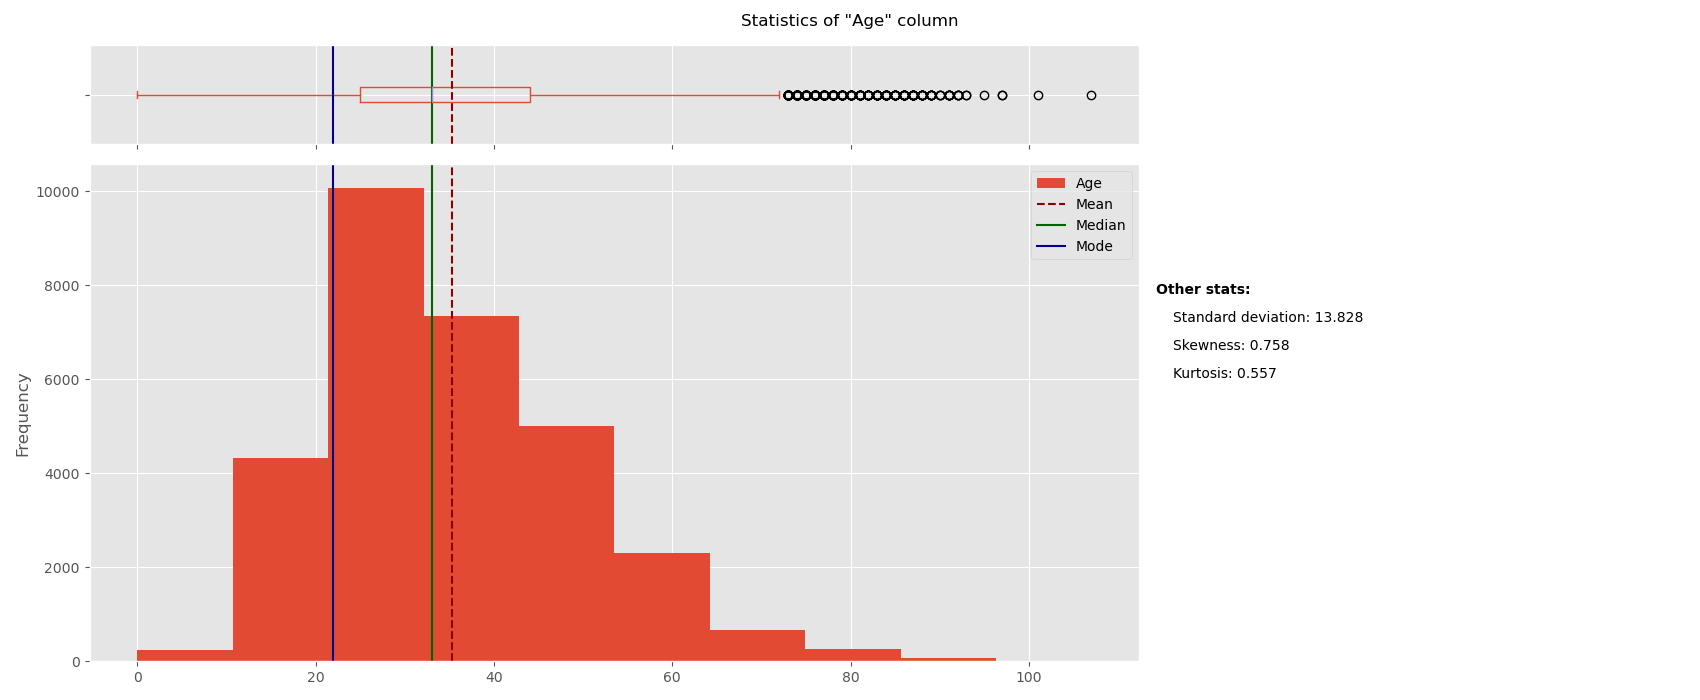

In [17]:
numerical_columns = ["Age"]

for column in numerical_columns:
	# noinspection PyTypeChecker
	mmmssk_fig, (mmmssk_box_ax, mmmssk_hist_ax) = pyplot.subplots(
		nrows=2, ncols=1,
		sharex=True,
		gridspec_kw={"height_ratios": (0.2, 1)}
	)
	mmmssk_fig.suptitle(f"Statistics of \"{column}\" column")

	mean = data_fe[column].mean()
	median = data_fe[column].median()
	mode = data_fe[column].mode().values[0]

	data_fe[column].plot(ax=mmmssk_box_ax, kind="box", vert=False, legend=True)
	mmmssk_box_ax.axvline(mean, color="darkred", linestyle="--")
	mmmssk_box_ax.axvline(median, color="darkgreen", linestyle="-")
	mmmssk_box_ax.axvline(mode, color="darkblue", linestyle="-")

	data_fe[column].plot(ax=mmmssk_hist_ax, kind="hist", legend=True)
	mmmssk_hist_ax.axvline(mean, color="darkred", linestyle="--", label="Mean")
	mmmssk_hist_ax.axvline(median, color="darkgreen", linestyle="-", label="Median")
	mmmssk_hist_ax.axvline(mode, color="darkblue", linestyle="-", label="Mode")

	mmmssk_box_ax.set_yticklabels([""])
	mmmssk_hist_ax.legend()

	standard_deviation = data_fe[column].std()
	skewness = data_fe[column].skew()
	kurtosis = data_fe[column].kurtosis()

	pyplot.figtext(0.68, 0.58, f"Other stats:", fontsize=10, fontweight="bold")
	pyplot.figtext(0.69, 0.54, f"Standard deviation: {round(standard_deviation, 3)}", fontsize=10)
	pyplot.figtext(0.69, 0.5, f"Skewness: {round(skewness, 3)}", fontsize=10)
	pyplot.figtext(0.69, 0.46, f"Kurtosis: {round(kurtosis, 3)}", fontsize=10)

	pyplot.tight_layout()
	pyplot.subplots_adjust(right=0.67)
	pyplot.show()

## Répartition des confrontations fatales entre citoyen et policier
Nous allons chercher à voir la répartition de ces confrontations selon plusieurs variables. Nous pourrons ainsi voir quelles sont les personnes les plus touchés par ça.

<IPython.core.display.Javascript object>


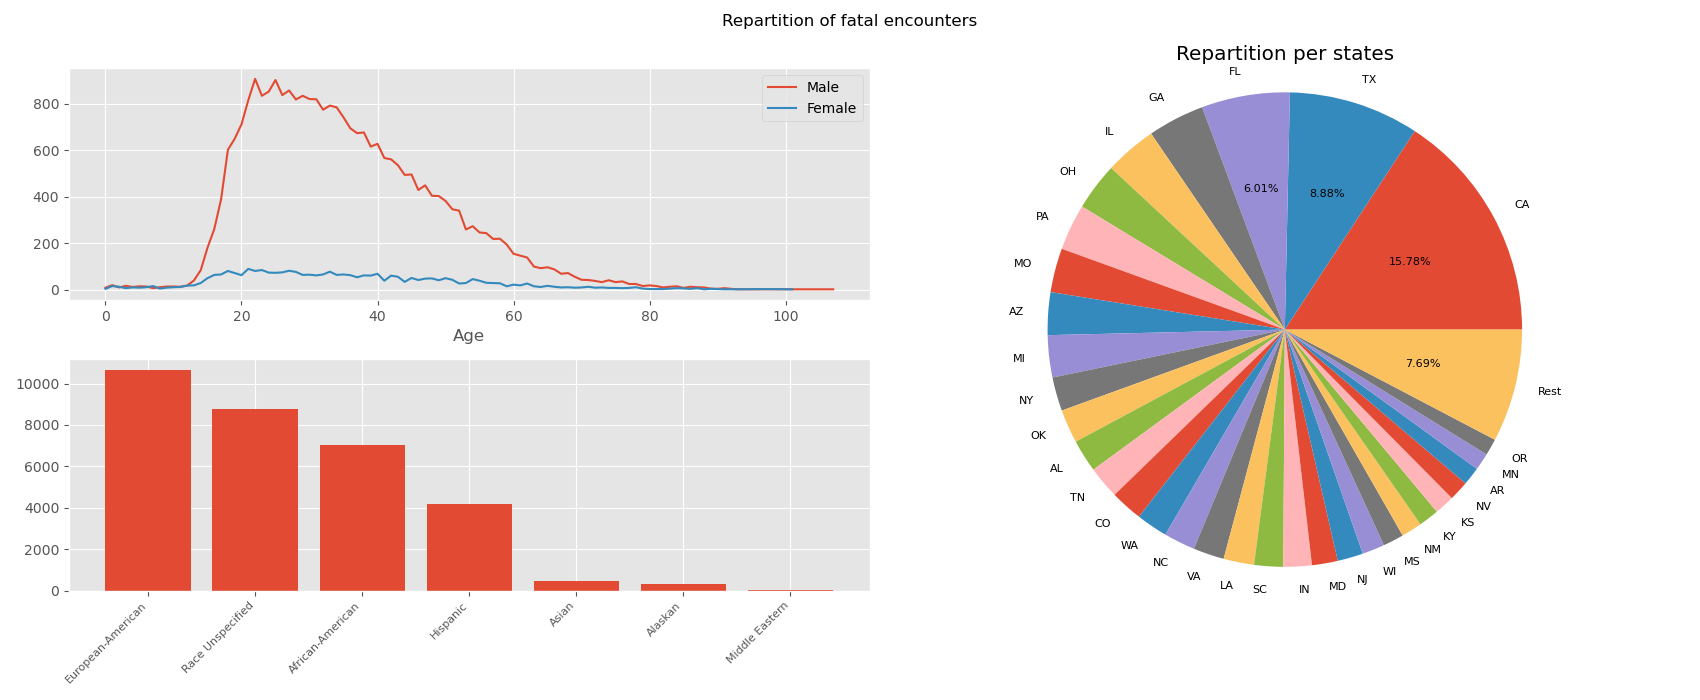

In [18]:
repart_fig = pyplot.figure()
repart_size = (2, 2)
repart_grid = repart_fig.add_gridspec(repart_size[0], repart_size[1])

_ = repart_fig.suptitle("Repartition of fatal encounters")

### Répartition par âge et par sexe

In [19]:
male_labels = data_fe["Age"][data_fe["Gender"] == "Male"].drop_duplicates(keep="first", inplace=False).dropna().sort_values()
male_values = data_fe["Age"][data_fe["Gender"] == "Male"].value_counts().sort_index()

female_labels = data_fe["Age"][data_fe["Gender"] == "Female"].drop_duplicates(keep="first", inplace=False).dropna().sort_values()
female_values = data_fe["Age"][data_fe["Gender"] == "Female"].value_counts().sort_index()

gender_ax = pyplot.subplot(repart_grid[0, :-1])
gender_ax.plot(male_labels, male_values.tolist(), label="Male")
gender_ax.plot(female_labels, female_values.tolist(), label="Female")

gender_ax.set_xlabel("Age")
_ = gender_ax.legend()

### Répartition par ethnies

In [20]:
# Revert one hot encoding
ethnic_data = data_fe[[column for column in data_fe if column.startswith("Race_")]].idxmax(1)
ethnic_data = ethnic_data.map(lambda ethnic: ethnic.replace("Race_", "").title())

ethnic_values = ethnic_data.value_counts().sort_values(ascending=False)
ethnic_labels = pandas.Series(data=ethnic_values.index, index=ethnic_values)

ethnic_ax = pyplot.subplot(repart_grid[1, :-1])
ethnic_ax.bar(ethnic_labels, ethnic_values.tolist())

_ = ethnic_ax.set_xticks(
	ticks=numpy.arange(0, len(ethnic_labels)),
	labels=ethnic_labels,
	rotation=45, fontsize=8, ha="right"
)

### Répartition par état

In [21]:
# Fatal encounters per state
def autopct_func(pct):
	return f"{round(pct, 2)}%" if pct > 5 else ""

# Get states
states = data_fe["State"].sort_values()
states_values = states.value_counts().sort_values(ascending=False)

# Merge states with low values
states_threshold = 1
states_to_merge = states_values[states_values <= ((states_values.sum() * states_threshold) / 100)]
states_values = pandas.concat([
	states_values.drop(states_values.tail(n=len(states_to_merge)).index),
	pandas.Series(data=sum(states_to_merge), index=["Rest"])
])

# Get states labels
states_labels = pandas.Series(data=states_values.index, index=states_values)

# Plot
states_ax = pyplot.subplot(repart_grid[0:, -1])
states_ax.pie(states_values.tolist(), labels=states_labels, autopct=autopct_func, textprops={"fontsize": 8})
states_ax.axis("equal")
_ = states_ax.set_title("Repartition per states")

Enfin, il ne reste qu'à afficher les graphiques.

In [22]:
pyplot.tight_layout()
pyplot.show()

## Test du khi-deux

<IPython.core.display.Javascript object>


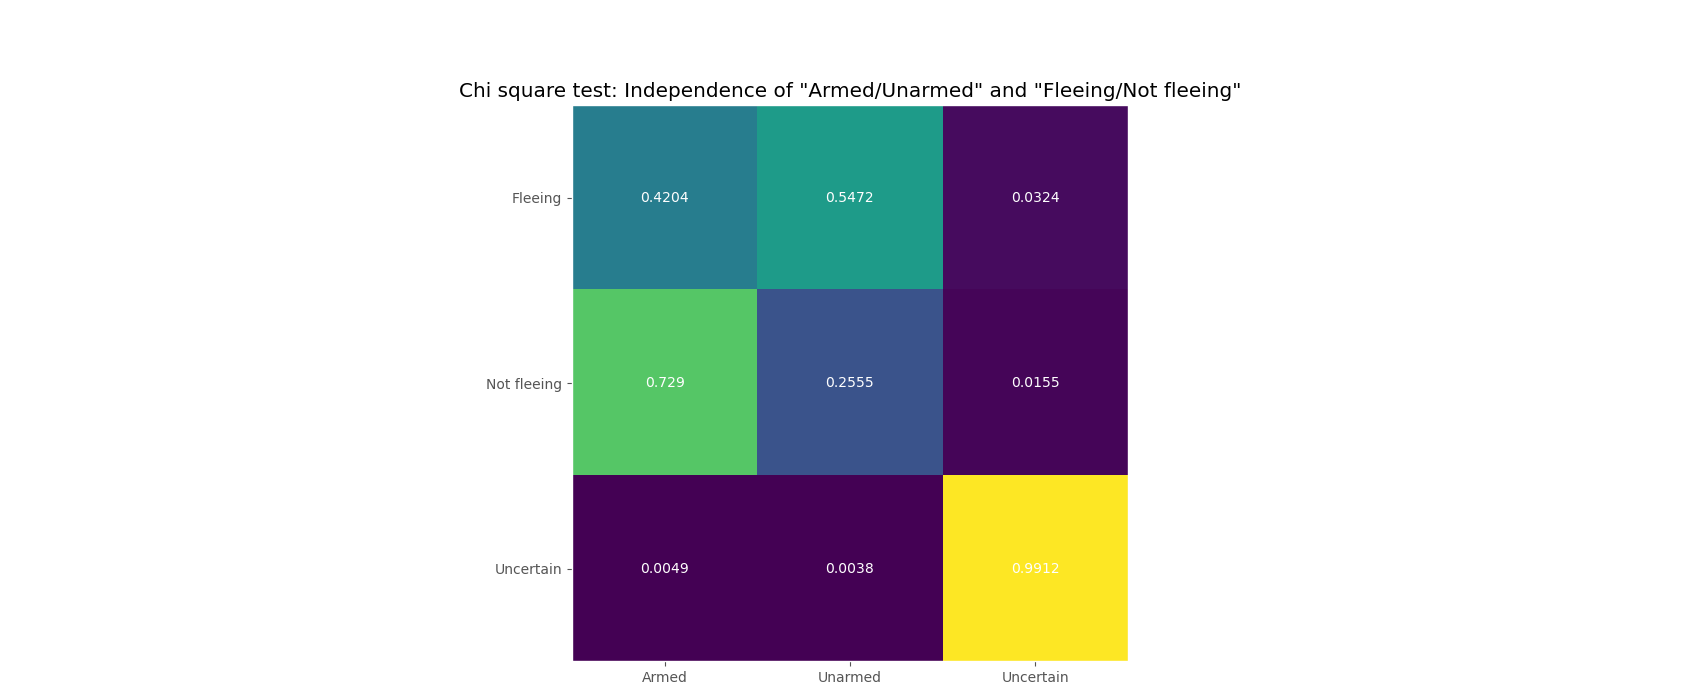

Degree of freedom: 4
Expected frequencies: [[0.38477949 0.26884229 0.34637821]
 [0.38477949 0.26884229 0.34637821]
 [0.38474101 0.26881541 0.34634357]]
Interpret the test-statistic: (Probability: 0.95 | Critical: 9.488 | Stat: 3.038) >>> Dependent: False
Interpret the p-value: (Significance: 0.05 | P-Value: 0.552) >>> Dependent: False


In [23]:
# Contingency table
contingency = pandas.crosstab(
	index=data_fe["Fleeing/Not fleeing"],
	columns=data_fe["Armed/Unarmed"],
	normalize="index"
).round(4)
contingency_numpy = contingency.to_numpy()

chi_labels_armed = contingency.columns.tolist()
chi_labels_fleeing = contingency.index.tolist()

# Plot to heatmap
chi_fig, chi_ax = pyplot.subplots()

chi_ax.imshow(contingency_numpy)
chi_ax.set_xticks(numpy.arange(len(chi_labels_armed)), labels=chi_labels_armed)
chi_ax.set_yticks(numpy.arange(len(chi_labels_fleeing)), labels=chi_labels_fleeing)

for i in range(len(chi_labels_fleeing)):
	for j in range(len(chi_labels_armed)):
		chi_ax.text(j, i, contingency_numpy[i, j], ha="center", va="center", color="w")

# Interpret statistics
stat, pvalue, dof, expected = scipy.stats.chi2_contingency(contingency)

print(f"Degree of freedom: {Fore.LIGHTGREEN_EX}{dof}{Fore.RESET}")
print(f"Expected frequencies: {Fore.LIGHTGREEN_EX}{expected}{Fore.RESET}")

prob = 0.95
critical = scipy.stats.chi2.ppf(prob, dof)
print((
	f"Interpret the test-statistic: "
	f"{Style.DIM}{Fore.WHITE}(Probability: {round(prob, 3)} | Critical: {round(critical, 3)} | Stat: {round(stat, 3)}) "
	f"{Style.RESET_ALL}{Fore.LIGHTGREEN_EX}>>> Dependent: {abs(stat) >= critical}{Fore.RESET}"
))

alpha = 1.0 - prob
print((
	f"Interpret the p-value: "
	f"{Style.DIM}{Fore.WHITE}(Significance: {round(alpha, 3)} | P-Value: {round(pvalue, 3)}) "
	f"{Style.RESET_ALL}{Fore.LIGHTGREEN_EX}>>> Dependent: {pvalue <= alpha}{Fore.RESET}"
))

# Finish plot
chi_ax.set_title(
	"Chi square test: Independence of \"Armed/Unarmed\" and \"Fleeing/Not fleeing\"",
	loc="center",
	wrap=True
)
chi_ax.grid(False)
chi_fig.tight_layout()
chi_fig.subplots_adjust(top=0.85)
pyplot.show()

## Répartition par états

In [24]:
class Map:
	def __init__(self, crs="EPSG:3857", **kwargs):
		self.crs = crs
		self.lat_lon_df = None
		self.geometry_df = None

		self.map = folium.Map(tiles=None, crs=self.crs.replace(":", ""), **kwargs)
		self._add_tile_layers()

	def _add_tile_layers(self):
		layers = [
			{"name": "openstreetmap", "display_name": "Open Street Map"},
			{"name": "stamentoner", "display_name": "Stamen toner"},
			{"name": "cartodbpositron", "display_name": "CartoDB (Light)"},
			{"name": "cartodbdark_matter", "display_name": "CartoDB (Dark)"},
		]

		for layer in layers:
			folium.TileLayer(layer["name"], name=layer["display_name"]).add_to(self.map)

	def load_from_gcs(self, df, lat_name="Latitude", lon_name="Longitude"):
		self.lat_lon_df = df[[lat_name, lon_name]].copy()
		self.geometry_df = GeoDataFrame(
			df,
			geometry=geopandas.points_from_xy(self.lat_lon_df[lon_name], self.lat_lon_df[lat_name]),
			crs=self.crs
		)

	def add_heatmap(self, color_map=False, layered=False, **kwargs):
		heat_data = [[point.xy[1][0], point.xy[0][0]] for point in self.geometry_df.geometry if not point.is_empty]

		if color_map:
			heat_map = folium.plugins.HeatMap(heat_data, gradient={0.4: "blue", 0.65: "lime", 1: "red"}, **kwargs)
		else:
			heat_map = folium.plugins.HeatMap(heat_data, **kwargs)

		if layered:
			feature_group = folium.FeatureGroup(name="Heat Map")
			feature_group.tile_name = "Heat Map"
			heat_map.add_to(feature_group)

		heat_map.add_to(self.map)

		if layered:
			folium.LayerControl().add_to(self.map)

	def fit_bounds(self):
		south_west_bound = self.lat_lon_df.min().values.tolist()
		north_east_bound = self.lat_lon_df.max().values.tolist()
		self.map.fit_bounds([south_west_bound, north_east_bound])

	def open(self, notebook=False, output_dir="./temp", filename=None):
		if notebook:
			return self.map

		path = os.path.join(output_dir, (filename if filename else f"map-{time.time()}.html"))

		self.map.save(path)
		webbrowser.open(path)

encounter_map = Map()
encounter_map.load_from_gcs(data_fe, lat_name="Latitude", lon_name="Longitude")
encounter_map.add_heatmap(layered=True, min_opacity=0.4, radius=20, blur=20)
encounter_map.fit_bounds()
encounter_map.open(notebook=True)